In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
from sklearn.ensemble import RandomForestRegressor

In [4]:
fontsize = 14

# Loading the data sets

We load two synthetic data sets, which both are generated assuming one uniform $\alpha(t)$ function for _all_ growth curves : one which is populated as normal (grid of 32 x 48 per plate) and one where the populations are decreased by 1/4th (only every 4th position is occupied) :

In [5]:
Nt = np.moveaxis(np.load("mean-ci_full-data.npy"), 1, 3)
Nt4 = np.moveaxis(np.load("mean-ci_1-fourth-data.npy"), 1, 3)

Let's calculate the relative growth rates $\rho_i(t) = \frac{\Delta N_i}{\Delta t}(t) \times \frac{1}{N_i}(t)$ :

In [6]:
rho = (Nt[..., 1:] - Nt[..., :-1]) / Nt[..., :-1]
rho4 = (Nt4[..., 1:] - Nt4[..., :-1]) / Nt4[..., :-1]

/tmp/ipykernel_144997/2402470352.py:2: RuntimeWarning: invalid value encountered in divide
  rho4 = (Nt4[..., 1:] - Nt4[..., :-1]) / Nt4[..., :-1]


Now let's make two data frames containing all the information we need, starting with the one for the full data :

In [7]:
factors = pd.MultiIndex.from_product((np.arange(4), np.arange(415), np.arange(32), np.arange(48)), names = ("plate", "", "row", "column")).to_frame()
factors.index = pd.MultiIndex.from_frame(factors)

Let's get for every position if it's a bottom-right of a subsets lattice, and which layer it is part of :

In [8]:
factors["fourth"] = (factors["row"] % 2 == 1) & (factors["column"] % 2 == 1)
factors["layer"] = pd.concat((factors["row"], factors["column"], 32-1-factors["row"], 48-1-factors["column"]), axis = "columns").min(axis = "columns")

This part of the metadata is the same for both data frames, so let's create the one for 1/4th of the populations :

In [9]:
factors4 = factors.copy()

We use every 4th position as test set ; for the data containing only 1/4th of the populations, we need to adapt this further :

In [10]:
factors["test"] = factors["fourth"]
factors["train"] = (factors["test"] != True)

factors4["test"] = (factors4["row"] % 4 == 3) & (factors4["column"] % 4 == 3)
factors4["train"] = (factors4["test"] != True)

Finally we populate the data frames :

In [11]:
factors["N(t)"] = np.moveaxis(Nt[..., :-1], 3, 1).reshape(-1)
factors["rho(t)"] = np.moveaxis(rho, 3, 1).reshape(-1)

factors4["N(t)"] = np.moveaxis(Nt4[..., :-1], 3, 1).reshape(-1)
factors4["rho(t)"] = np.moveaxis(rho4, 3, 1).reshape(-1)

And we keep in factors4 only the data points in every 4th position :

In [12]:
factors4 = factors4[factors4["fourth"]]

# Regressions

Next we apply regression models $x_i, N_i(t) \mapsto \rho_i(t)$ for every time point :

### Full population plates

In [13]:
scores = pd.DataFrame(index = pd.MultiIndex.from_product((np.arange(4), ("train", "test")), names = ("plate", "t")), columns = np.arange(415))
importances = pd.DataFrame(index = pd.MultiIndex.from_product((np.arange(4), ("row", "column", "N(t)")), names = ("plate", "factor")), columns = np.arange(415))

In [14]:
for p in range(4):
    for t in range(415):
        train, test = factors[factors["train"]].loc[(p, t)], factors[factors["test"]].loc[(p, t)]
        
        m = RandomForestRegressor().fit(train[["row", "column", "N(t)"]], train["rho(t)"])
        scores.loc[(p, "train"), t] = m.score(train[["row", "column", "N(t)"]], train["rho(t)"])
        scores.loc[(p, "test"), t] = m.score(test[["row", "column", "N(t)"]], test["rho(t)"])
        importances.loc[p, t] = m.feature_importances_

### Every 4th position plates

In [15]:
scores4 = scores.copy()
importances4 = importances.copy()

In [16]:
for p in range(4):
    for t in range(415):
        train, test = factors4[factors4["train"]].loc[(p, t)], factors4[factors4["test"]].loc[(p, t)]
        
        m = RandomForestRegressor().fit(train[["row", "column", "N(t)"]], train["rho(t)"])
        scores4.loc[(p, "train"), t] = m.score(train[["row", "column", "N(t)"]], train["rho(t)"])
        scores4.loc[(p, "test"), t] = m.score(test[["row", "column", "N(t)"]], test["rho(t)"])
        importances4.loc[p, t] = m.feature_importances_

# Figures

In [17]:
indexes = [1, 2, 3, 0]
names = ["Glc", "Glc + NaCl", "Gal", "Gal + NaCl"]

### Full population plates

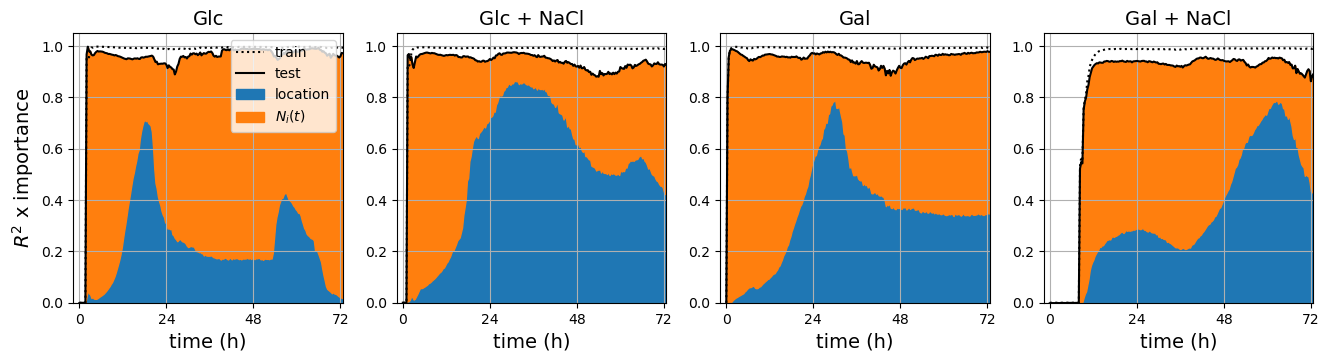

In [18]:
fig, axes = plt.subplots(ncols = 4, figsize = (16, 3.5))

for p, env, ax in zip(indexes, names, axes):
    ts = np.arange(415)
    ax.plot(scores.loc[(p, "train")], color = "black", linestyle = ":", label = "train")
    sts = scores.loc[(p, "test")]
    ax.plot(sts, color = "black", label = "test")
    
    a = importances.loc[(p, "N(t)")]
    ax.fill_between(x = ts, y1 = 0, y2 = list(sts * (1-a)), color = "tab:blue", label = "location")
    ax.fill_between(x = ts, y1 = list(sts * (1-a)), y2 = list(sts), color = "tab:orange", label = "$N_i(t)$")
    ax.set_ylim(0, 1.05)
    
    ax.set_xlabel("time (h)", fontsize = fontsize)
    ax.set_xticks([0, 72, 144, 216, 288, 360, 432], labels = [0, 24, 48, 72, 96, 120, 144])
    ax.set_xlim(-5, 218)
    
    ax.set_title(env, fontsize = fontsize)
    ax.grid()

axes[0].set_ylabel("$R^2$ x importance", fontsize = fontsize)
axes[0].legend(loc = "upper right")

fig.savefig(f"plots/figure-s5/ml-full.pdf", bbox_inches = "tight")
fig.savefig(f"plots/figure-s5/ml-full.png", bbox_inches = "tight");

### Every 4th position plates

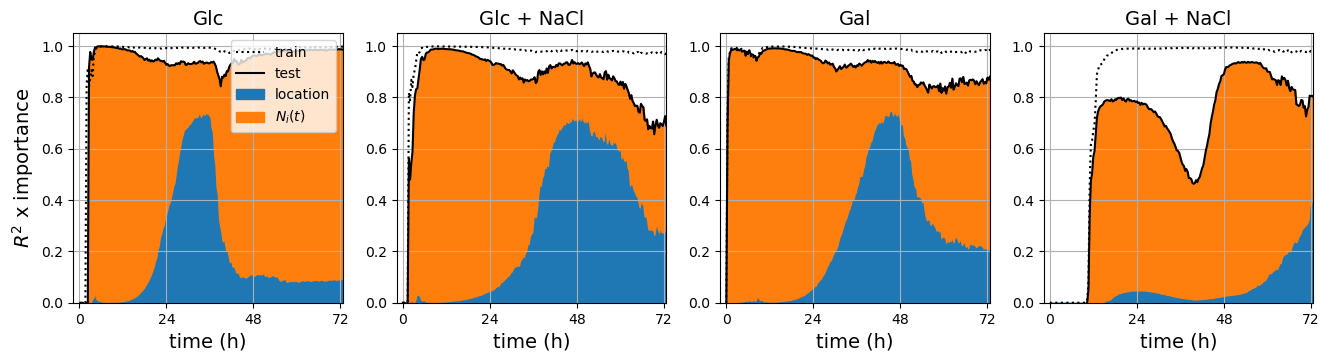

In [19]:
fig, axes = plt.subplots(ncols = 4, figsize = (16, 3.5))

for p, env, ax in zip(indexes, names, axes):
    ts = np.arange(415)
    ax.plot(scores4.loc[(p, "train")], color = "black", linestyle = ":", label = "train")
    sts = scores4.loc[(p, "test")]
    ax.plot(sts, color = "black", label = "test")
    
    a = importances4.loc[(p, "N(t)")]
    ax.fill_between(x = ts, y1 = 0, y2 = list(sts * (1-a)), color = "tab:blue", label = "location")
    ax.fill_between(x = ts, y1 = list(sts * (1-a)), y2 = list(sts), color = "tab:orange", label = "$N_i(t)$")
    ax.set_ylim(0, 1.05)
    
    ax.set_xlabel("time (h)", fontsize = fontsize)
    ax.set_xticks([0, 72, 144, 216, 288, 360, 432], labels = [0, 24, 48, 72, 96, 120, 144])
    ax.set_xlim(-5, 218)
    
    ax.set_title(env, fontsize = fontsize)
    ax.grid()

axes[0].set_ylabel("$R^2$ x importance", fontsize = fontsize)
axes[0].legend(loc = "upper right")

fig.savefig(f"plots/figure-s5/ml-4th.pdf", bbox_inches = "tight")
fig.savefig(f"plots/figure-s5/ml-4th.png", bbox_inches = "tight");